In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines

import os
import sys
sys.path.append('../')
from data import VOC_CLASSES
from models.ssd_new_mobilenet_FFA import build_ssd

In [2]:
imgsetpath = os.path.join('../data/VOCdevkit', 'VOC2007', 'ImageSets', 'Main', '{:s}.txt')
imgpath = os.path.join('../data/VOCdevkit', 'VOC2007', 'JPEGImages', '%s.jpg')
annopath = os.path.join('../data/VOCdevkit', 'VOC2007', 'Annotations', '%s.xml')

imgsetfile = imgsetpath.format('hand_test_big')
with open(imgsetfile, 'r') as f:
    imagenames = f.readlines()
imagenames = [x.strip() for x in imagenames]

## Load detection model

In [3]:
net = build_ssd('test', size=300, num_classes=2)
trained_model = '../weights/ssd_new_mobilenet_FFA.pth'
net.load_weights(trained_model)
net.eval()
net = net.cuda()
cudnn.benchmark = True

Loading weights into state dict...
Finished!


## Functions for detecting and plotting

In [4]:
def draw_predictions(ax, boxes):
    rects = boxes[:,0:4]
    w_vec = boxes[:,(4,5)]
    h_vec = boxes[:,(6,7)]
    wrists = boxes[:,(8,9)]
    
    centers = (rects[:,(0,1)]+rects[:,(2,3)])/2
    wrists_offset = wrists - centers
    wrists_direc = np.sign(wrists_offset)
    h_vec = h_vec * wrists_direc
    w_vec = w_vec * np.matmul( wrists_direc, np.array([ [0,1],[-1,0]]))
    
    ## adjust w_vec
    w_vec_dir = np.matmul( h_vec / np.linalg.norm(h_vec,axis=1,keepdims=True), np.array([ [0,1],[-1,0]]))
    w_vec = np.sum(w_vec * w_vec_dir,axis=1,keepdims=True) * w_vec_dir
    
    ##
    pa = centers + h_vec/2 + w_vec/2
    pb = centers + h_vec/2 - w_vec/2
    pc = centers - h_vec/2 - w_vec/2
    pd = centers - h_vec/2 + w_vec/2
    
    for i in range(boxes.shape[0]):
        rect = rects[i,:]
        wristp = wrists[i,:]
        a,b,c,d = pa[i,:],pb[i,:],pc[i,:],pd[i,:]
        
        # upright bbox
        color1 = (0,1,0)
        rect=patches.Rectangle( (rect[0], rect[1]),rect[2]-rect[0],rect[3]-rect[1],linewidth=1,edgecolor=color1,facecolor='none')
        ax.add_patch(rect)
        
        # rotated bbox
        color2 = (1,0,0)
        ax.add_line( lines.Line2D([a[0],b[0]],[a[1],b[1]],color=color2, lw=1) )
        ax.add_line( lines.Line2D([b[0],c[0]],[b[1],c[1]],color=color2, lw=1) )
        ax.add_line( lines.Line2D([c[0],d[0]],[c[1],d[1]],color=color2, lw=1) )
        ax.add_line( lines.Line2D([d[0],a[0]],[d[1],a[1]],color=color2, lw=1) )
        
        # 
        color3 = color2
        start_p = centers[i,:]
        end_p = (c+d)/2
        ax.arrow( start_p[0], start_p[1], end_p[0]-start_p[0], end_p[1]-start_p[1], color=color3, lw=1, head_width=10, head_length=10)
        
def view_detected_hands(img_name):
    img = cv2.imread( imgpath % img_name)
    h,w,c = img.shape
    img_rz = cv2.resize(img, (300,300))
    x = (img_rz.astype(np.float32) / 255.0 - 0.5)*2
    x = Variable(torch.from_numpy(x).permute(2, 0, 1).unsqueeze(0))
    x = x.cuda()

    ## predictions
    dets = net(x).data
    dets = dets[0, 1, :]
    mask = dets[:, 0].gt(0.).expand(11, dets.size(0)).t()
    dets = torch.masked_select(dets, mask).view(-1, 11)
    if dets.dim()==0:
        return
    boxes = dets[:, 1:]
    boxes[:, (0,2,4,6,8)] *= w
    boxes[:, (1,3,5,7,9)] *= h
    scores = dets[:, 0].cpu().numpy()
    cls_dets = np.hstack((boxes.cpu().numpy(), scores[:, np.newaxis])).astype(np.float32, copy=False)

    ## show results with confidence > 0.5
    if cls_dets.shape[0]!=0:
        cls_dets = cls_dets[ cls_dets[:,-1]>0.5, :10]
    if cls_dets.shape[0]==0:
        return
    else:
        plt.figure(figsize=[6,6])
        draw_predictions(plt.gca(), cls_dets)
        plt.imshow(img[:,:,::-1])

## View  Results

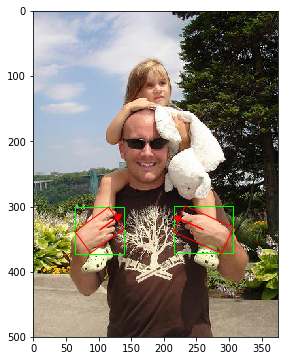

In [8]:
img_name = '009985_hand'
view_detected_hands(img_name)

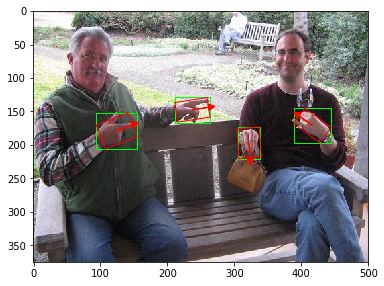

In [9]:
img_name = '010184_hand'
view_detected_hands(img_name)

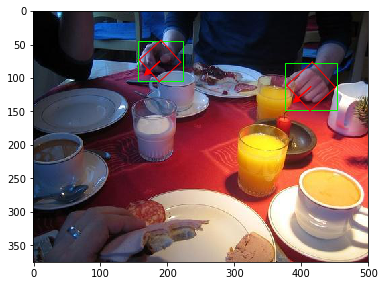

In [10]:
img_name = '010268_hand'
view_detected_hands(img_name)